### Imports

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
from datetime import datetime
from src import utils, plot
from src.detector import CategoricalDriftDetector, ContinuousDriftDetector
from src.tracker import PerformanceTracker
from sklearn.metrics import f1_score
from scipy.stats import ks_2samp

### Data

In [2]:
# Parâmetros
n_samples = 100000 
n_features = 20  
n_informative = 2   # Número de características informativas
n_redundant = 2    # Número de características redundantes
weights = [0.2, 0.8]  # Desbalanceamento
np.random.seed(42)
# Gerar os dados
X, y = make_classification(n_samples=n_samples, 
                           n_features=n_features, 
                           n_informative=n_informative, 
                           n_redundant=n_redundant, 
                           flip_y=0.05, 
                           random_state=42,
                           )

# Adicionar coluna com duas categorias
category_col = np.random.choice([0, 1], size=n_samples, p=weights)

# Adicionar coluna com diversas categorias (por exemplo, 5 categorias)
diverse_category_col = np.random.choice([0, 1, 2, 3, 4], size=n_samples)


In [3]:
# Criar DataFrame
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
df['discrete_0'] = category_col
df['discrete_1'] = diverse_category_col
df['target'] = y
df['datetime'] = utils.generate_random_dates_within_interval(datetime(2021, 1, 1), 4, n_samples)
df_train = df[df["datetime"] < '2024']
df_reference = df[(df["datetime"] >= '2024-01-01') & (df["datetime"] < '2024-07-01')].copy()
df_test = df[(df["datetime"] >= '2024-07-01')].copy()

In [4]:
X_train = df_train[df_train.columns[:-2]]
y_train = df_train["target"]

### Training

In [5]:
rf = RandomForestClassifier(random_state=42, oob_score=True, n_jobs=-1, class_weight="balanced")
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, oob_score=True,
                       random_state=42)

### df_test

In [6]:
y_prob = rf.predict_proba(df_test[df_test.columns[:-2]])
y_pred = rf.predict(df_test[df_test.columns[:-2]])
y_prob = y_prob[np.arange(len(df_test)), y_pred]
df_test["y_prob"] = y_prob
df_test["prediction"] = y_pred

### df_reference

In [7]:
y_prob = rf.predict_proba(df_reference[df_reference.columns[:-2]])
y_pred = rf.predict(df_reference[df_reference.columns[:-2]])
y_prob = y_prob[np.arange(len(y_prob)), y_pred]
df_reference["y_prob"] = y_prob
df_reference["prediction"] = y_pred

### Performance

In [8]:
tracker = PerformanceTracker(df_reference, 'target', 'prediction', 'datetime', "W")

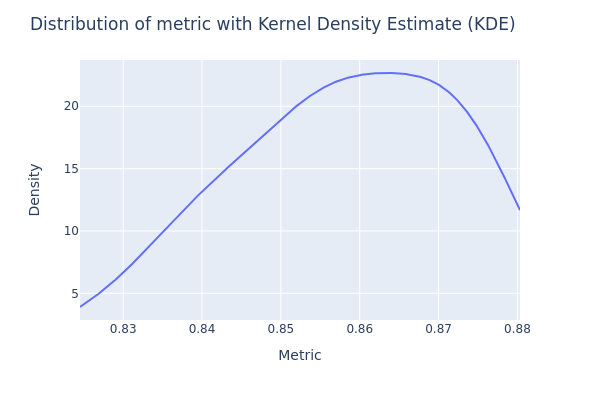

In [9]:
tracker.plot.kde(fig_type="png")

### Reference Plot

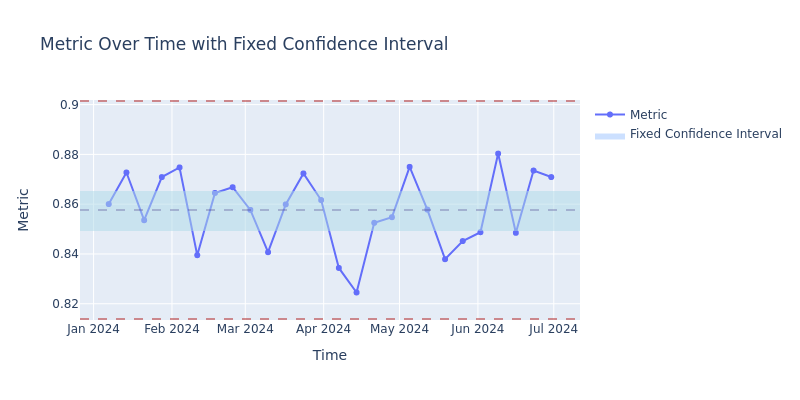

In [10]:
tracker.plot.performance_by_time(tracker.reference_distribution, fig_type="png")

### Analysis Plot

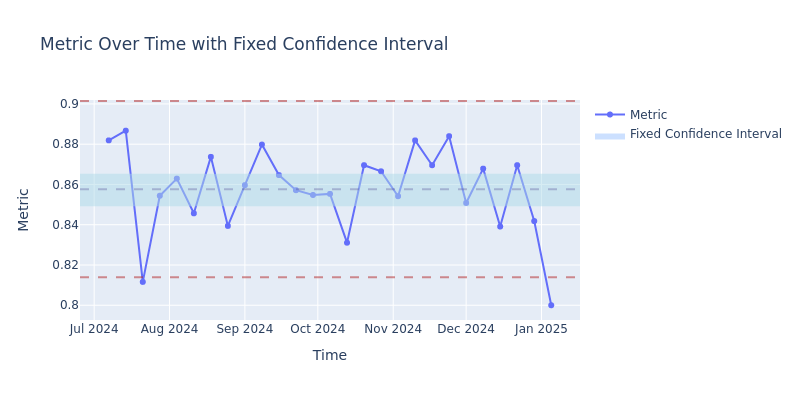

In [11]:
analysis_score = tracker._calculate_metric(df_test, 'target', 'prediction', 'datetime', 'W', f1_score)
tracker.plot.performance_by_time(analysis_score, fig_type="png")

# Discrete Data Drift

In [12]:
# Exemplo de uso:
detector = CategoricalDriftDetector(df_reference, 'discrete_1', "datetime", "W")

### Reference Plot

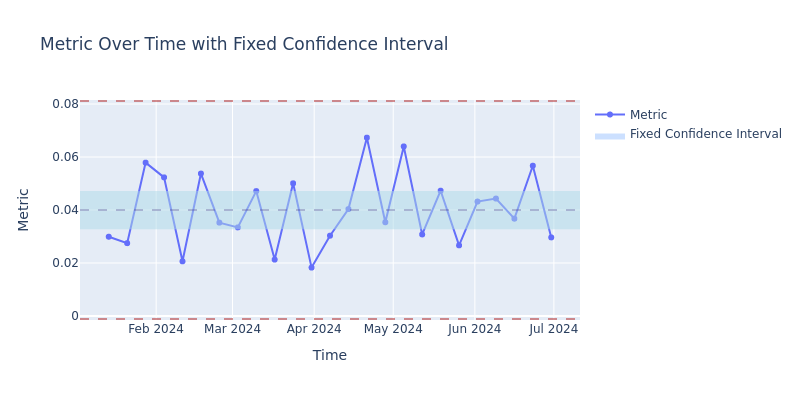

In [13]:
detector.plot.performance_by_time(detector.reference_distance, fig_type="png")

### Reference Analysis

In [14]:
analysis_distribution = detector._calculate_frequency(df_test, "discrete_1", "datetime", "W")
analysis_distance = detector._generate_distance(analysis_distribution, distance_func= "l_infinity")

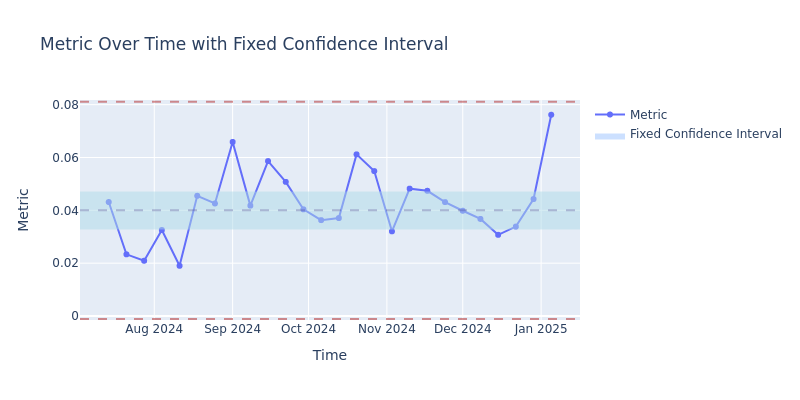

In [15]:
detector.plot.performance_by_time(analysis_distance, fig_type="png")

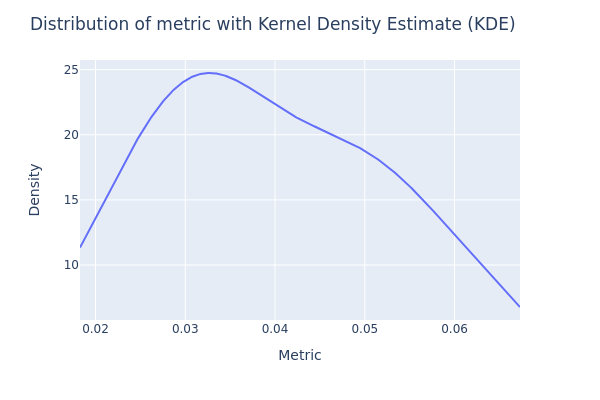

In [16]:
detector.plot.kde(fig_type="png")

# Continuous Data Drift

In [17]:
ks = ContinuousDriftDetector(df_reference, "feature_0", "datetime", "W", thresholds=(0.05, None))

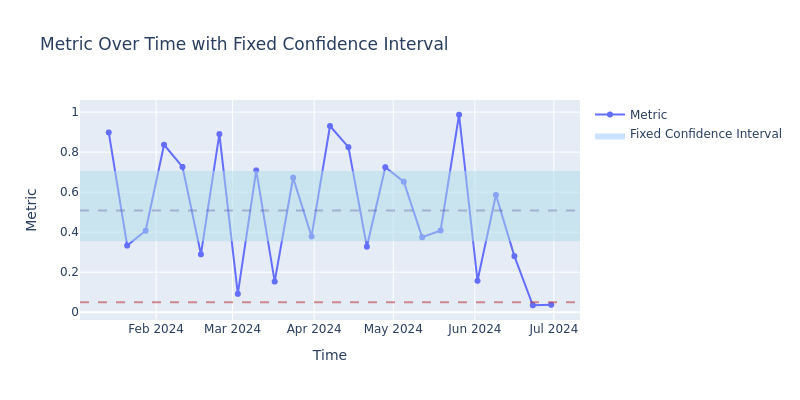

In [18]:
ks.plot.performance_by_time(ks.reference_ks, fig_type="png")

In [19]:
reference = np.concatenate(ks.reference_distribution)
test_distribution = ks._calculate_distribution(df_test, "feature_0", "datetime", "W")
test_ks = test_distribution.apply(lambda x: ks_2samp(x, reference)[1]).rename("metric").reset_index()

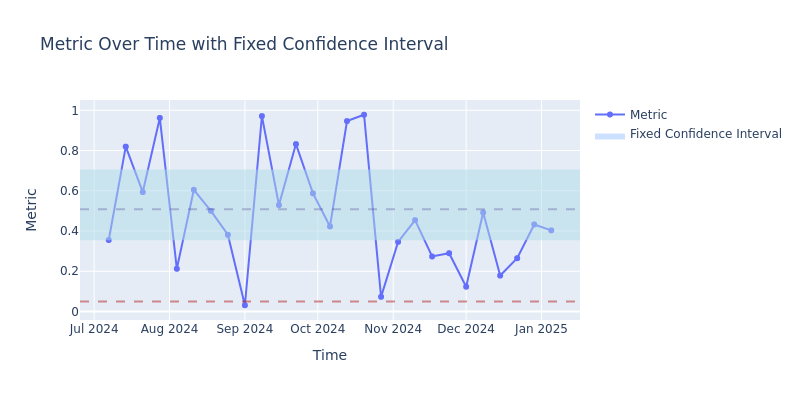

In [20]:
ks.plot.performance_by_time(test_ks, fig_type="png")

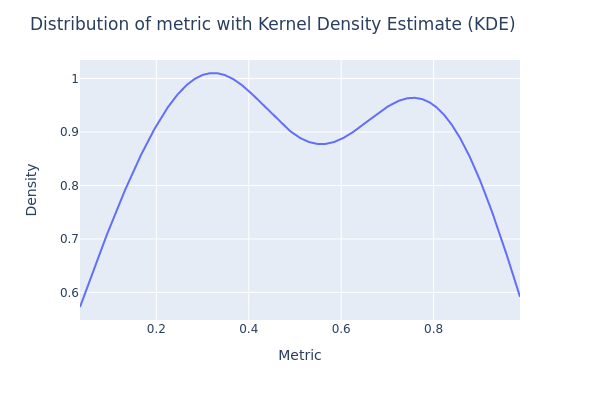

In [21]:
ks.plot.kde(fig_type="png")